In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from finance_byu.summarize import summary
import statsmodels.formula.api as smf
import yfinance as yf

### Data Loading

In [21]:
df = pd.read_parquet("~/Data/BOQ_data.parquet")

df.tail()

,A2ME,BEME,BEME_adj,BEME_ind,CEI,DATE,DEC_ME,DEC_SHROUT,Div,Div_ann,...,s2invt,s2rect,sale,sale_ind,sales_g,sga2s,spread_mean,std_turn,std_vol,suv
3568650,0.211263,0.114912,-0.746238,0.861151,-12.189408,2023-08-31,3.897415e+08,3164000.0,0.0,0.0,...,6.344887,26.084534,81462.0,579615.973,0.513517,0.086187,0.000152,0.708916,2.250092e+07,-1.580970
3568651,0.211263,0.114912,-0.750723,0.865635,-11.613183,2023-09-30,3.897415e+08,3164000.0,0.0,0.0,...,6.344887,26.084534,81462.0,579615.973,0.513517,0.086187,0.000133,0.465122,1.476294e+07,-0.371920
3568652,0.211263,0.114912,-0.731231,0.846143,-12.752123,2023-10-31,3.897415e+08,3164000.0,0.0,0.0,...,6.344887,26.084534,81462.0,579615.973,0.513517,0.086187,0.000177,0.531342,1.686876e+07,0.809301
3568653,0.211263,0.114912,-0.731231,0.846143,-7.943286,2023-11-30,3.897415e+08,3164000.0,0.0,0.0,...,6.344887,26.084534,81462.0,579615.973,0.513517,0.086187,0.000245,0.614813,1.954419e+07,0.278301
3568654,0.211263,0.114912,-0.731231,0.846143,-9.359996,2023-12-31,3.897415e+08,3164000.0,0.0,0.0,...,6.344887,26.084534,81462.0,579615.973,0.513517,0.086187,0.000186,0.599491,1.905735e+07,0.967711


In [22]:
# Create initial dataframe. Keep only necessary columns, and generate date variables

keep = ['DATE', 'PERMNO', 'BEME', 'E2P', 'sale', 'ME', 'PRC', 'RET', ]

df = df[keep]

df = df.rename(columns={'DATE':'caldt','PERMNO':'permno','BEME':'beme', 'E2P': 'ep', 'sale': 'sales', 'ME': 'me', 'PRC':'prc', 'RET': 'ret'})

df = df.sort_values(['permno','caldt'])

df['mdt'] = df['caldt'].dt.strftime("%Y-%m")
df['month'] = df['caldt'].dt.strftime("%m")
df['year'] = df['caldt'].dt.strftime("%Y")

# In sample period
# start = '1963-04-01'
# end = '1990-04-30'

# Out of sample period
start = '1990-04-30'
end = '2024-10-07'

df = df[df['caldt'] >= start]
df = df[df['caldt'] <= end]

df = df.reset_index(drop=True)

df.tail()

,caldt,permno,beme,ep,sales,me,prc,ret,mdt,month,year
2044042,2023-08-31,93436.0,0.114912,0.032216,81462.0,8.191443e+08,258.079987,-0.034962,2023-08,08,2023
2044043,2023-09-30,93436.0,0.114912,0.032216,81462.0,7.954494e+08,250.220001,-0.030456,2023-09,09,2023
2044044,2023-10-31,93436.0,0.114912,0.032216,81462.0,6.384545e+08,200.839996,-0.197346,2023-10,10,2023
2044045,2023-11-30,93436.0,0.114912,0.032216,81462.0,7.631954e+08,240.080002,0.195379,2023-11,11,2023
2044046,2023-12-31,93436.0,0.114912,0.032216,81462.0,7.898983e+08,248.479996,0.034988,2023-12,12,2023


Feature Generation

In [23]:
# Generate features from the last 12 months

formation_period = 12 # months

# 1 month sales growth
df['sg'] = df.groupby("permno")['sales'].pct_change(fill_method=None)

# Log 1 months sales growth
df['log_sg'] = np.log(1+df['sg'])

# Past 1 year log sales growth
df[f'log_sg_{formation_period}'] = df.groupby('permno').rolling(formation_period,formation_period)['log_sg'].sum().reset_index(drop=True)

df.tail()

/Users/andrew/Projects/Quant/mean_reversion/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/andrew/Projects/Quant/mean_reversion/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,caldt,permno,beme,ep,sales,me,prc,ret,mdt,month,year,sg,log_sg,log_sg_12
2044042,2023-08-31,93436.0,0.114912,0.032216,81462.0,8.191443e+08,258.079987,-0.034962,2023-08,08,2023,0.0,0.0,0.414436
2044043,2023-09-30,93436.0,0.114912,0.032216,81462.0,7.954494e+08,250.220001,-0.030456,2023-09,09,2023,0.0,0.0,0.414436
2044044,2023-10-31,93436.0,0.114912,0.032216,81462.0,6.384545e+08,200.839996,-0.197346,2023-10,10,2023,0.0,0.0,0.414436
2044045,2023-11-30,93436.0,0.114912,0.032216,81462.0,7.631954e+08,240.080002,0.195379,2023-11,11,2023,0.0,0.0,0.414436
2044046,2023-12-31,93436.0,0.114912,0.032216,81462.0,7.898983e+08,248.479996,0.034988,2023-12,12,2023,0.0,0.0,0.414436


In [24]:
# Generate target variable

# Log 1 month return
df['log_ret'] = np.log(1 + df['ret'])

holding_period = 1 # months

# 12 month holding period return
df[f'ret_{holding_period}'] = df.groupby('permno').rolling(holding_period,holding_period)['log_ret'].sum().reset_index(drop=True)
df[f'ret_{holding_period}'] = df.groupby('permno')[f'ret_{holding_period}'].shift(-(holding_period-1))

df.tail()

,caldt,permno,beme,ep,sales,me,prc,ret,mdt,month,year,sg,log_sg,log_sg_12,log_ret,ret_1
2044042,2023-08-31,93436.0,0.114912,0.032216,81462.0,8.191443e+08,258.079987,-0.034962,2023-08,08,2023,0.0,0.0,0.414436,-0.035588,-0.035588
2044043,2023-09-30,93436.0,0.114912,0.032216,81462.0,7.954494e+08,250.220001,-0.030456,2023-09,09,2023,0.0,0.0,0.414436,-0.030929,-0.030929
2044044,2023-10-31,93436.0,0.114912,0.032216,81462.0,6.384545e+08,200.839996,-0.197346,2023-10,10,2023,0.0,0.0,0.414436,-0.219832,-0.219832
2044045,2023-11-30,93436.0,0.114912,0.032216,81462.0,7.631954e+08,240.080002,0.195379,2023-11,11,2023,0.0,0.0,0.414436,0.178464,0.178464
2044046,2023-12-31,93436.0,0.114912,0.032216,81462.0,7.898983e+08,248.479996,0.034988,2023-12,12,2023,0.0,0.0,0.414436,0.034390,0.034390


In [25]:
# Lag all formation variables by 1 month
df['beme_lag'] = df.groupby('permno')['beme'].shift(1)
df['sg_lag'] = df.groupby('permno')[f'log_sg_{formation_period}'].shift(1)
df['prc_lag'] = df.groupby('permno')['prc'].shift(1)

# Remove stocks that don't have formation variables and low priced stocks
df = df.query("beme_lag == beme_lag and sg_lag == sg_lag and prc_lag >= 5").reset_index(drop=True)

df.tail()

,caldt,permno,beme,ep,sales,me,prc,ret,mdt,month,year,sg,log_sg,log_sg_12,log_ret,ret_1,beme_lag,sg_lag,prc_lag
1174594,2023-08-31,93436.0,0.114912,0.032216,81462.0,8.191443e+08,258.079987,-0.034962,2023-08,08,2023,0.0,0.0,0.414436,-0.035588,-0.035588,0.114912,0.414436,267.429993
1174595,2023-09-30,93436.0,0.114912,0.032216,81462.0,7.954494e+08,250.220001,-0.030456,2023-09,09,2023,0.0,0.0,0.414436,-0.030929,-0.030929,0.114912,0.414436,258.079987
1174596,2023-10-31,93436.0,0.114912,0.032216,81462.0,6.384545e+08,200.839996,-0.197346,2023-10,10,2023,0.0,0.0,0.414436,-0.219832,-0.219832,0.114912,0.414436,250.220001
1174597,2023-11-30,93436.0,0.114912,0.032216,81462.0,7.631954e+08,240.080002,0.195379,2023-11,11,2023,0.0,0.0,0.414436,0.178464,0.178464,0.114912,0.414436,200.839996
1174598,2023-12-31,93436.0,0.114912,0.032216,81462.0,7.898983e+08,248.479996,0.034988,2023-12,12,2023,0.0,0.0,0.414436,0.034390,0.034390,0.114912,0.414436,240.080002


### Portfolio Formation

In [26]:
# Create quantiles based off of b/m lag and sales growth lag using independent sorts
df['beme_bins'] = df.groupby("mdt")['beme_lag'].transform(lambda x: pd.qcut(x, 3, labels=False))
df['sg_bins'] = df.groupby("mdt")['sg_lag'].transform(lambda x: pd.qcut(x, 3, labels=False))

df.tail()

,caldt,permno,beme,ep,sales,me,prc,ret,mdt,month,...,sg,log_sg,log_sg_12,log_ret,ret_1,beme_lag,sg_lag,prc_lag,beme_bins,sg_bins
1174594,2023-08-31,93436.0,0.114912,0.032216,81462.0,8.191443e+08,258.079987,-0.034962,2023-08,08,...,0.0,0.0,0.414436,-0.035588,-0.035588,0.114912,0.414436,267.429993,0,2
1174595,2023-09-30,93436.0,0.114912,0.032216,81462.0,7.954494e+08,250.220001,-0.030456,2023-09,09,...,0.0,0.0,0.414436,-0.030929,-0.030929,0.114912,0.414436,258.079987,0,2
1174596,2023-10-31,93436.0,0.114912,0.032216,81462.0,6.384545e+08,200.839996,-0.197346,2023-10,10,...,0.0,0.0,0.414436,-0.219832,-0.219832,0.114912,0.414436,250.220001,0,2
1174597,2023-11-30,93436.0,0.114912,0.032216,81462.0,7.631954e+08,240.080002,0.195379,2023-11,11,...,0.0,0.0,0.414436,0.178464,0.178464,0.114912,0.414436,200.839996,0,2
1174598,2023-12-31,93436.0,0.114912,0.032216,81462.0,7.898983e+08,248.479996,0.034988,2023-12,12,...,0.0,0.0,0.414436,0.034390,0.034390,0.114912,0.414436,240.080002,0,2


In [27]:
# Group stocks by year and bins
port = df.groupby(['mdt', 'beme_bins', 'sg_bins'])[f'ret_{holding_period}'].mean().unstack(level=['beme_bins', 'sg_bins'])

# Drop rows with no holding period returns
port = port.dropna()

# Value portfolio is high b/m and low sg
# Glamor portfolio is low b/m and high sg
# Create a spread portfolio with long value and short glamor stocks
port['spread'] = port[2][0] - port[0][2]

port_100 = port * 100

port_100.tail()

beme_bins         0                              1                       \
sg_bins           0         1          2         0         1          2   
mdt                                                                       
2023-08   -4.716655 -4.045008  -7.350230 -6.109166 -4.668065  -5.485214   
2023-09   -6.077890 -6.354159  -8.289402 -7.111974 -5.803892  -5.060810   
2023-10   -6.783416 -5.766300 -10.071209 -5.652653 -5.492372  -7.560092   
2023-11    8.876797  8.446312  10.239403  8.564323  8.969777   6.319965   
2023-12    9.441034  7.978027  10.352894  9.270339  9.541762  10.718418   

beme_bins          2                         spread  
sg_bins            0          1         2            
mdt                                                  
2023-08    -5.178535  -5.829315 -5.664164  2.171695  
2023-09    -6.036356  -5.317427 -6.022551  2.253046  
2023-10    -5.839624  -5.247019 -9.178652  4.231584  
2023-11     7.158502   9.397076  6.834299 -3.080900  
2023-12    11.782687  13.353666  9.906198  1.429793

### Portfolio Summary Table

In [28]:
# Portfolio summary table

(summary(port_100).loc[['mean','std','tstat']]).round(3)

beme_bins      0                    1                    2                \
sg_bins        0      1      2      0      1      2      0      1      2   
mean      -0.150  0.392 -0.424  0.396  0.580  0.025  0.395  0.603  0.131   
std        5.730  4.907  6.928  4.967  4.806  5.898  5.085  4.800  5.632   
tstat     -0.517  1.581 -1.211  1.580  2.391  0.083  1.536  2.489  0.459   

beme_bins spread  
sg_bins           
mean       0.818  
std        4.425  
tstat      3.661

### Backtest

In [29]:
# Create backtest with monthly returns

backtest = port['spread'].reset_index().copy()

backtest = backtest.rename(columns={'spread': 'log_ret'})

# Cuummulative sum the log returns
backtest['cum_ret'] = backtest['log_ret'].cumsum()

# Create date column for plotting purposes
backtest['caldt'] = pd.to_datetime(backtest['mdt'])

backtest

,mdt,log_ret,cum_ret,caldt
0,1991-05,-0.002955,-0.002955,1991-05-01
1,1991-06,0.041586,0.038631,1991-06-01
2,1991-07,-0.016260,0.022371,1991-07-01
3,1991-08,-0.018842,0.003529,1991-08-01
4,1991-09,-0.020187,-0.016658,1991-09-01
...,...,...,...,...
387,2023-08,0.021717,3.159075,2023-08-01
388,2023-09,0.022530,3.181605,2023-09-01
389,2023-10,0.042316,3.223921,2023-10-01
390,2023-11,-0.030809,3.193112,2023-11-01


In [30]:
# Pull in benchmark data for plotting purposes

bmk = yf.download('^GSPC', start=start, end=end)

# Data preparation
bmk = bmk.reset_index()

bmk = bmk.rename(columns={'Date': 'caldt', 'Adj Close': 'prc'})

bmk = bmk[['caldt', 'prc']]

bmk['mdt'] = bmk['caldt'].dt.strftime("%Y-%m")

# Aggregate to monthly level
bmk = bmk.groupby('mdt').agg({'prc': 'first'}).reset_index()

bmk['caldt'] = pd.to_datetime(bmk['mdt'])

# Return metrics for plotting
bmk['ret'] = bmk['prc'].pct_change()
bmk['log_ret'] = np.log(1 + bmk['ret'])
bmk['cum_ret'] = bmk['log_ret'].cumsum()

bmk

[*********************100%***********************]  1 of 1 completed


,mdt,prc,caldt,ret,log_ret,cum_ret
0,1990-04,330.799988,1990-04-01,NaN,NaN,NaN
1,1990-05,332.250000,1990-05-01,0.004383,0.004374,0.004374
2,1990-06,363.160004,1990-06-01,0.093032,0.088956,0.093330
3,1990-07,359.540009,1990-07-01,-0.009968,-0.010018,0.083312
4,1990-08,355.519989,1990-08-01,-0.011181,-0.011244,0.072068
...,...,...,...,...,...,...
410,2024-06,5283.399902,2024-06-01,0.052808,0.051461,2.770811
411,2024-07,5475.089844,2024-07-01,0.036282,0.035639,2.806450
412,2024-08,5446.680176,2024-08-01,-0.005189,-0.005202,2.801248
413,2024-09,5528.930176,2024-09-01,0.015101,0.014988,2.816236


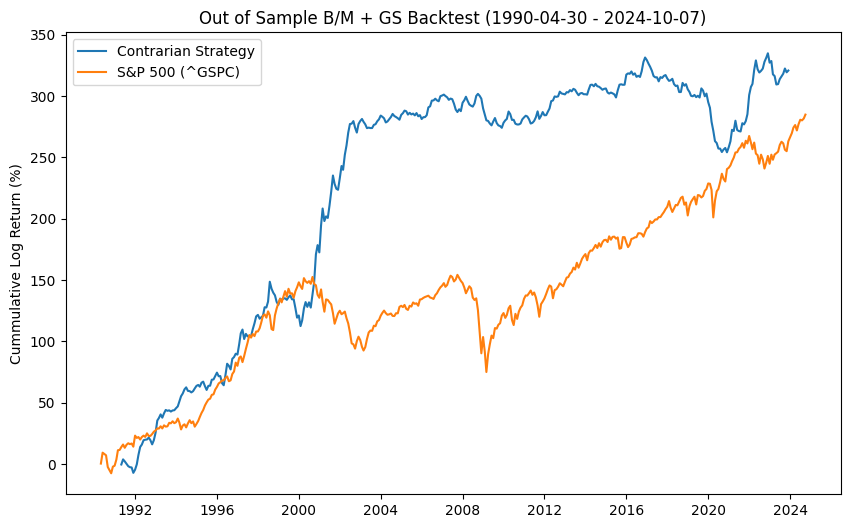

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(backtest['caldt'], backtest['cum_ret'] * 100, label='Contrarian Strategy')
plt.plot(bmk['caldt'], bmk['cum_ret'] * 100, label='S&P 500 (^GSPC)')
plt.title(f"Out of Sample B/M + GS Backtest ({start} - {end})")
plt.ylabel("Cummulative Log Return (%)")
plt.legend()
plt.show()

In [32]:
# Calculate napkin sharpe ratio using monthly returns

numerator = backtest['log_ret'].mean()
denominator = backtest['log_ret'].std()
scale = 12 / np.sqrt(12)

sharpe = numerator / denominator * scale

print(f"Sharpe Ratio: {round(sharpe,2)}")

Sharpe Ratio: 0.64


### 5 Factor Model Decomposition

In [33]:
# Pull in fama french 5 factors
fac = pd.read_csv("~/Data/fama_5_factors.csv")

# Create mdt variable for merging
fac['mdt'] = pd.to_datetime(fac['DATE'].astype(str), format='%Y%m').dt.strftime("%Y-%m")

fac

,DATE,Mkt-RF,SMB,HML,RMW,CMA,RF,mdt
0,196307,-0.39,-0.41,-0.97,0.68,-1.18,0.27,1963-07
1,196308,5.07,-0.80,1.80,0.36,-0.35,0.25,1963-08
2,196309,-1.57,-0.52,0.13,-0.71,0.29,0.27,1963-09
3,196310,2.53,-1.39,-0.10,2.80,-2.01,0.29,1963-10
4,196311,-0.85,-0.88,1.75,-0.51,2.24,0.27,1963-11
...,...,...,...,...,...,...,...,...
729,202404,-4.67,-2.56,-0.52,1.48,-0.30,0.47,2024-04
730,202405,4.34,0.76,-1.66,2.98,-3.07,0.44,2024-05
731,202406,2.77,-4.37,-3.31,0.51,-1.78,0.41,2024-06
732,202407,1.24,8.28,5.73,0.22,0.43,0.45,2024-07


In [34]:
# Merge port and fac 
merge = pd.merge(backtest, fac, on='mdt', how='inner')

# Drop unecessary columns
merge = merge.drop(columns=['cum_ret', 'caldt', 'DATE'])

merge['log_ret'] = merge['log_ret'] * 100

merge['xs_log_ret'] = merge['log_ret'] - merge['RF']

merge = merge.rename(columns={'Mkt-RF': 'XS_MKT'})

merge

,mdt,log_ret,XS_MKT,SMB,HML,RMW,CMA,RF,xs_log_ret
0,1991-05,-0.295518,3.65,0.14,-0.52,2.00,-2.43,0.47,-0.765518
1,1991-06,4.158578,-4.94,0.24,1.15,1.79,0.65,0.42,3.738578
2,1991-07,-1.625954,4.24,-0.96,-1.32,1.60,-1.36,0.49,-2.115954
3,1991-08,-1.884203,2.32,1.40,-0.78,0.84,-0.34,0.46,-2.344203
4,1991-09,-2.018661,-1.59,1.56,-1.08,-1.82,0.08,0.46,-2.478661
...,...,...,...,...,...,...,...,...,...
387,2023-08,2.171695,-2.39,-3.68,-1.08,3.42,-2.37,0.45,1.721695
388,2023-09,2.253046,-5.24,-1.79,1.45,1.85,-0.84,0.43,1.823046
389,2023-10,4.231584,-3.18,-4.05,0.19,2.47,-0.67,0.47,3.761584
390,2023-11,-3.080900,8.83,-0.11,1.66,-3.81,-0.99,0.44,-3.520900


In [35]:
# Run a single factor model regression
model = smf.ols("xs_log_ret ~ XS_MKT", data=merge).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             xs_log_ret   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     105.1
Date:                Tue, 08 Oct 2024   Prob (F-statistic):           5.36e-22
Time:                        08:27:20   Log-Likelihood:                -1090.7
No. Observations:                 392   AIC:                             2185.
Df Residuals:                     390   BIC:                             2193.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9535      0.201      4.752      0.000       0.559       1.348
XS_MKT        -0.4597      0.045    -10.252      0.000      -0.548      -0.372
==============================================================================
Omnibus:                       29.676   Durbin-Watson:                   1.479
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              118.568
Skew:                           0.050   Prob(JB):                     1.79e-26
Kurtosis:                       5.692   Cond. No.                         4.54
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
# Run a 5 factor model regression
model = smf.ols("xs_log_ret ~ XS_MKT + SMB + HML + RMW + CMA", data=merge).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             xs_log_ret   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     355.2
Date:                Tue, 08 Oct 2024   Prob (F-statistic):          5.92e-142
Time:                        08:27:20   Log-Likelihood:                -799.78
No. Observations:                 392   AIC:                             1612.
Df Residuals:                     386   BIC:                             1635.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4621      0.100      4.631      0.000       0.266       0.658
XS_MKT        -0.2579      0.024    -10.597      0.000      -0.306      -0.210
SMB           -0.0548      0.036     -1.539      0.125      -0.125       0.015
HML            0.6841      0.041     16.868      0.000       0.604       0.764
RMW            0.2575      0.045      5.754      0.000       0.169       0.345
CMA            0.5843      0.061      9.567      0.000       0.464       0.704
==============================================================================
Omnibus:                       16.918   Durbin-Watson:                   1.702
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.923
Skew:                           0.109   Prob(JB):                     2.14e-09
Kurtosis:                       4.548   Cond. No.                         5.22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
# True sharpe ratio (includes the risk free rate)

numerator = (merge['log_ret'] - merge['RF']).mean()
denominator = merge['log_ret'].std()
scale = 12 / np.sqrt(12)

sharpe = numerator / denominator * scale

print(f"Sharpe Ratio: {round(sharpe,2)}")

Sharpe Ratio: 0.49


In [38]:
# Market sharpe over the same period

numerator = fac['Mkt-RF'].mean()
denominator = (fac['Mkt-RF'] + fac['RF']).std()
scale = 12 / np.sqrt(12)

sharpe = numerator / denominator * scale

print(f"Market Sharpe Ratio: {round(sharpe, 2)}")

Market Sharpe Ratio: 0.45
